In [1]:
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from scipy import stats

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## HRNet result from github

### process 816x288

In [2]:
# load true data

val_816x288 = json.load(open("annotation_images/val_82_cp.json"))

In [3]:
w48_384x288 = json.load(open("/Users/alexxu/Desktop/test/keypoints_val_results_0.json"))

In [5]:
len(w48_384x288)

47

### calculate Euclidean distance

In [6]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [7]:
def get_true_val_kps(image_id):
    for i in range(len(val_816x288['annotations'])):
        if val_816x288['annotations'][i]['image_id'] == image_id:
            return np.array(val_816x288['annotations'][i]['keypoints']).reshape(-1, 3)[:, :-1]

In [8]:
def get_val_kps(image_id, model_result):
    for i in range(len(model_result)):
        if model_result[i]['image_id'] == image_id:
            return np.array(model_result[i]['keypoints']).reshape(-1, 3)[:, :-1]

In [9]:
get_val_kps(132, w48_384x288)

array([[102.04427338,  90.9765625 ],
       [170.6640625 ,  93.19010162],
       [ 77.6953125 , 108.68489838],
       [195.01301575, 110.8984375 ],
       [ 95.40364838, 139.67448425],
       [175.09114075, 144.1015625 ],
       [119.75260162, 175.09114075],
       [152.95573425, 175.09114075],
       [137.4609375 , 166.23698425],
       [110.8984375 , 133.03385925],
       [159.59635925, 135.24739075],
       [137.4609375 , 113.11197662],
       [135.24739075, 155.16926575],
       [ 84.3359375 , 146.31510925],
       [186.15885925, 150.7421875 ],
       [119.75260162, 166.23698425],
       [152.95573425, 166.23698425]])

In [10]:
get_true_val_kps(132)

array([[101,  91],
       [169,  92],
       [ 78, 110],
       [193, 112],
       [ 94, 140],
       [177, 143],
       [116, 174],
       [155, 175],
       [136, 167],
       [110, 131],
       [161, 132],
       [135, 110],
       [136, 156],
       [ 83, 146],
       [186, 149],
       [118, 166],
       [152, 167]])

In [11]:
# model_res = {"w32_256x192": w32_256x192, "w32_384x288": w32_384x288, "w48_256x192": w48_256x192, "w48_384x288": w48_384x288, "res50_256x192": res50_256x192, "res50_384x288": res50_384x288, "res101_256x192": res101_256x192, "res101_384x288": res101_384x288, "res152_256x192": res152_256x192, "res152_384x288": res152_384x288}

model_res = {"w48_384x288": w48_384x288}

hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_righ']

In [12]:
len(hip_regions)

17

In [13]:
all_model_df = pd.DataFrame(columns = hip_regions + ['model', 'image_id'])

for model_name, model in model_res.items():
    df = pd.DataFrame(columns = hip_regions)
    for i in range(len(model)):
        image_id = model[i]['image_id']
        true_kps = get_true_val_kps(image_id)
        val_kps = get_val_kps(image_id, model)
        for j in range(len(hip_regions)):
            ed = cal_euclidean_distance(true_kps[j][0], true_kps[j][1], val_kps[j][0], val_kps[j][1])
            df.loc[i, hip_regions[j]] = ed
        df.loc[i, 'image_id'] = "{:05d}".format(image_id)
    df['model'] = model_name
    all_model_df = pd.concat([all_model_df, df])

In [14]:
cal_euclidean_distance(get_true_val_kps(132)[0][0], get_true_val_kps(132)[0][1], get_val_kps(132, w48_384x288)[0][0], get_val_kps(132, w48_384x288)[0][1])

1.0445363570501198

In [15]:
all_model_df

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ,model,image_id
0,1.044536,2.045836,1.349936,2.294705,1.440899,2.203902,3.908018,2.046296,1.64819,2.22346,3.537761,3.967444,1.120955,1.372597,1.749415,1.768551,1.222956,w48_384x288,00132
1,2.591598,1.833002,1.77399,1.502121,3.546502,0.55581,0.909937,2.147208,1.237447,1.999516,1.674478,4.39709,0.172618,0.685014,2.348138,2.574461,2.794279,w48_384x288,00398
2,1.552802,5.058356,1.393295,3.258212,2.707975,1.634459,1.044354,1.648604,1.055231,1.496004,1.364388,2.292903,1.457406,1.387088,2.342554,1.710277,1.459975,w48_384x288,01643
3,1.62106,1.112224,2.308064,1.284071,0.981389,1.471615,1.07262,1.12336,0.187825,1.76116,0.86982,1.267415,3.127557,0.734589,0.059498,1.45157,2.645984,w48_384x288,01751
4,2.347927,1.941149,4.948527,5.049685,5.456748,1.018392,2.176563,2.316903,3.730267,3.185365,0.504447,2.258812,2.216746,1.749415,0.873453,0.694574,0.77119,w48_384x288,02754
5,3.917936,1.413811,0.561981,0.754586,1.336671,1.253055,0.879764,1.883182,3.109552,1.834148,1.102452,1.113248,1.392608,1.09152,0.961504,2.734455,0.606515,w48_384x288,03108
6,4.41004,1.995615,0.830375,1.693633,4.705874,1.595562,1.838459,1.388216,1.905619,0.539572,1.487253,1.547902,1.07396,2.085778,1.983376,1.388218,2.246282,w48_384x288,03736
7,0.831419,3.013652,0.451793,0.769185,0.639978,3.211357,0.655182,2.208543,2.606997,2.710002,1.695582,4.532265,1.634211,0.78635,0.72083,0.91377,0.688299,w48_384x288,04255
8,5.294116,1.010021,2.898953,2.138417,0.932458,0.60696,1.107063,1.529619,2.394961,1.752206,1.517871,1.82916,1.413238,0.957298,0.61534,0.963531,0.328025,w48_384x288,04401
9,3.994946,3.001078,1.394282,2.107558,4.781489,2.655318,1.766338,2.145516,1.942237,1.093832,0.675935,0.394681,2.061292,0.957294,0.672956,0.704271,0.938832,w48_384x288,05022


In [35]:
all_model_df.to_csv("./results/edistance_model_hipregion_82_cp.csv", index = False)

In [36]:
all_model_df

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ,model,image_id
0,1.044536,2.045836,1.349936,2.294705,1.440899,2.203902,3.908018,2.046296,1.64819,2.22346,3.537761,3.967444,1.120955,1.372597,1.749415,1.768551,1.222956,w48_384x288,00132
1,2.591598,1.833002,1.77399,1.502121,3.546502,0.55581,0.909937,2.147208,1.237447,1.999516,1.674478,4.39709,0.172618,0.685014,2.348138,2.574461,2.794279,w48_384x288,00398
2,1.552802,5.058356,1.393295,3.258212,2.707975,1.634459,1.044354,1.648604,1.055231,1.496004,1.364388,2.292903,1.457406,1.387088,2.342554,1.710277,1.459975,w48_384x288,01643
3,1.62106,1.112224,2.308064,1.284071,0.981389,1.471615,1.07262,1.12336,0.187825,1.76116,0.86982,1.267415,3.127557,0.734589,0.059498,1.45157,2.645984,w48_384x288,01751
4,2.347927,1.941149,4.948527,5.049685,5.456748,1.018392,2.176563,2.316903,3.730267,3.185365,0.504447,2.258812,2.216746,1.749415,0.873453,0.694574,0.77119,w48_384x288,02754
5,3.917936,1.413811,0.561981,0.754586,1.336671,1.253055,0.879764,1.883182,3.109552,1.834148,1.102452,1.113248,1.392608,1.09152,0.961504,2.734455,0.606515,w48_384x288,03108
6,4.41004,1.995615,0.830375,1.693633,4.705874,1.595562,1.838459,1.388216,1.905619,0.539572,1.487253,1.547902,1.07396,2.085778,1.983376,1.388218,2.246282,w48_384x288,03736
7,0.831419,3.013652,0.451793,0.769185,0.639978,3.211357,0.655182,2.208543,2.606997,2.710002,1.695582,4.532265,1.634211,0.78635,0.72083,0.91377,0.688299,w48_384x288,04255
8,5.294116,1.010021,2.898953,2.138417,0.932458,0.60696,1.107063,1.529619,2.394961,1.752206,1.517871,1.82916,1.413238,0.957298,0.61534,0.963531,0.328025,w48_384x288,04401
9,3.994946,3.001078,1.394282,2.107558,4.781489,2.655318,1.766338,2.145516,1.942237,1.093832,0.675935,0.394681,2.061292,0.957294,0.672956,0.704271,0.938832,w48_384x288,05022


### Plot

In [37]:
melt_all_model_df = all_model_df.melt(id_vars = ['model', 'image_id'], value_vars = hip_regions); melt_all_model_df

,model,image_id,variable,value
0,w48_384x288,00132,iliac_crest_left,1.044536
1,w48_384x288,00398,iliac_crest_left,2.591598
2,w48_384x288,01643,iliac_crest_left,1.552802
3,w48_384x288,01751,iliac_crest_left,1.62106
4,w48_384x288,02754,iliac_crest_left,2.347927
...,...,...,...,...
794,w48_384x288,20093,obturator_righ,2.313495
795,w48_384x288,20181,obturator_righ,1.029546
796,w48_384x288,20614,obturator_righ,2.96786
797,w48_384x288,21502,obturator_righ,3.325705


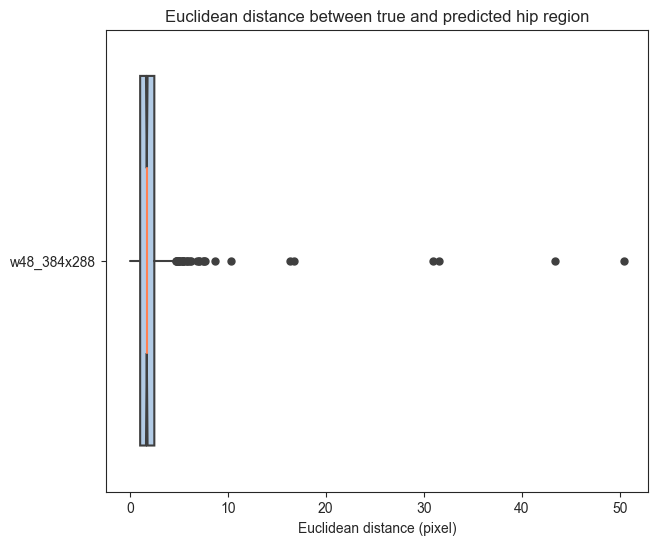

In [38]:
# test
order = melt_all_model_df.groupby('model')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(7, 6))
sns.boxplot(
    data=melt_all_model_df, x="value", y="model",
    notch=True, showcaps=False,
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_model_hipregion_82_cp.pdf", bbox_inches = 'tight')

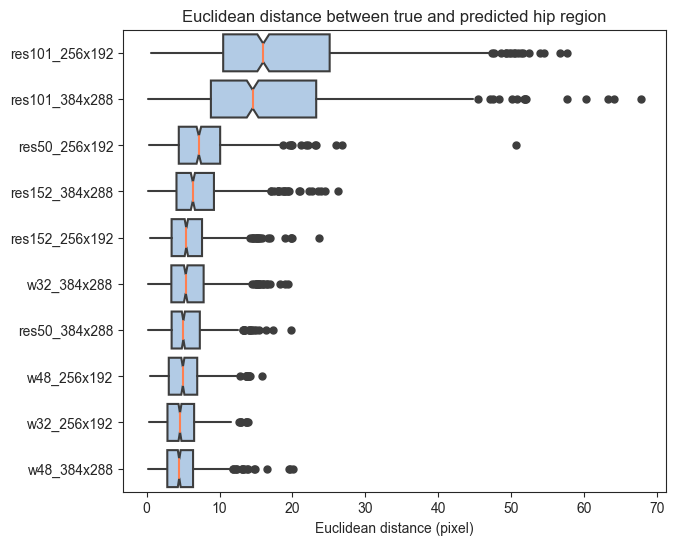

In [180]:
order = melt_all_model_df.groupby('model')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(7, 6))
sns.boxplot(
    data=melt_all_model_df, x="value", y="model",
    notch=True, showcaps=False,
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_model_hipregion_82.pdf", bbox_inches = 'tight')

### Use w48_384x288 as optimal model

In [39]:
subset_df = all_model_df[all_model_df['model'] == 'w48_384x288']

In [40]:
melt_subset_df = subset_df.melt(id_vars = 'model', value_vars = hip_regions); melt_subset_df

,model,variable,value
0,w48_384x288,iliac_crest_left,1.044536
1,w48_384x288,iliac_crest_left,2.591598
2,w48_384x288,iliac_crest_left,1.552802
3,w48_384x288,iliac_crest_left,1.62106
4,w48_384x288,iliac_crest_left,2.347927
...,...,...,...
794,w48_384x288,obturator_righ,2.313495
795,w48_384x288,obturator_righ,1.029546
796,w48_384x288,obturator_righ,2.96786
797,w48_384x288,obturator_righ,3.325705


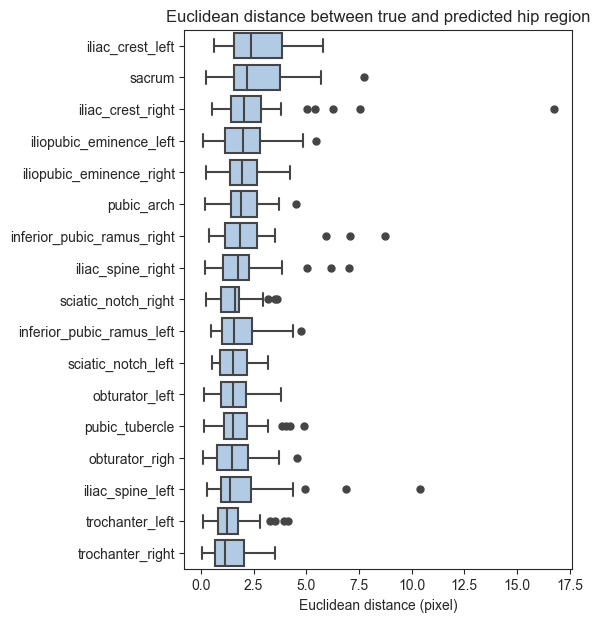

In [80]:
# test
subset_df = all_model_df[all_model_df['model'] == 'w48_384x288']
### remove one image
subset_df = subset_df[subset_df['image_id'] != '18085']
melt_subset_df = subset_df.melt(id_vars = 'model', value_vars = hip_regions)
order = melt_subset_df.groupby('variable')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(5, 7))
sns.boxplot(
    data=melt_subset_df, x="value", y="variable",
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
# plt.xlim(0, 20)
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_hipregion_82_cp.pdf", bbox_inches = 'tight')

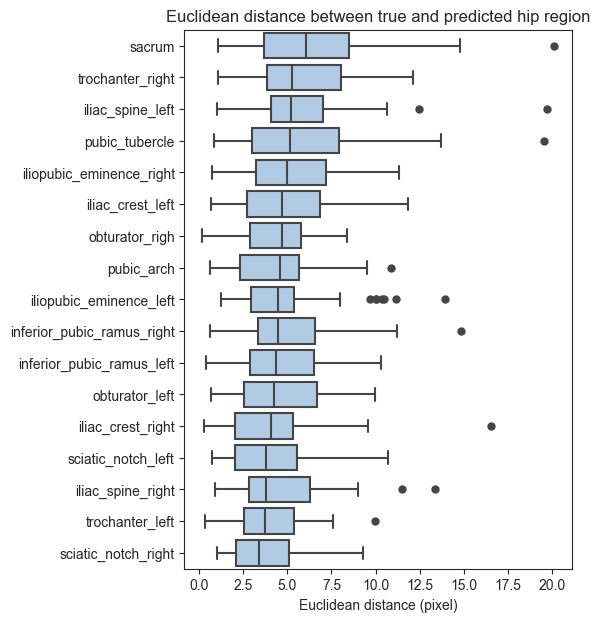

In [183]:
order = melt_subset_df.groupby('variable')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(5, 7))
sns.boxplot(
    data=melt_subset_df, x="value", y="variable",
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_hipregion_82.pdf", bbox_inches = 'tight')

### precess 960x384

In [140]:
# load true data

val_960x384 = json.load(open("annotation_images/val_960_384_17_idfilename.json"))

In [142]:
# load val data

w32_256x192 = json.load(open("output_93/hip_93_output/xray/pose_hrnet/w32_256x192_adam_lr1e-3/results/keypoints_val_results_0.json"))
w32_384x288 = json.load(open("output_93/hip_93_output/xray/pose_hrnet/w32_384x288_adam_lr1e-3/results/keypoints_val_results_0.json"))
w48_256x192 = json.load(open("output_93/hip_93_output/xray/pose_hrnet/w48_256x192_adam_lr1e-3/results/keypoints_val_results_0.json"))
w48_384x288 = json.load(open("output_93/hip_93_output/xray/pose_hrnet/w48_384x288_adam_lr1e-3/results/keypoints_val_results_0.json"))

res50_256x192 = json.load(open("output_93/hip_93_output/xray/pose_resnet/res50_256x192_d256x3_adam_lr1e-3/results/keypoints_val_results_0.json"))
res50_384x288 = json.load(open("output_93/hip_93_output/xray/pose_resnet/res50_384x288_d256x3_adam_lr1e-3/results/keypoints_val_results_0.json"))
res101_256x192 = json.load(open("output_93/hip_93_output/xray/pose_resnet/res101_256x192_d256x3_adam_lr1e-3/results/keypoints_val_results_0.json"))
res101_384x288 = json.load(open("output_93/hip_93_output/xray/pose_resnet/res101_384x288_d256x3_adam_lr1e-3/results/keypoints_val_results_0.json"))
res152_256x192 = json.load(open("output_93/hip_93_output/xray/pose_resnet/res152_256x192_d256x3_adam_lr1e-3/results/keypoints_val_results_0.json"))
res152_384x288 = json.load(open("output_93/hip_93_output/xray/pose_resnet/res152_384x288_d256x3_adam_lr1e-3/results/keypoints_val_results_0.json"))

In [143]:
len(res152_384x288)

46

### calculate Euclidean distance

In [151]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def get_true_val_kps(image_id):
    for i in range(len(val_960x384['annotations'])):
        if val_960x384['annotations'][i]['image_id'] == image_id:
            return np.array(val_960x384['annotations'][i]['keypoints']).reshape(-1, 3)[:, :-1]

def get_val_kps(image_id, model_result):
    for i in range(len(model_result)):
        if model_result[i]['image_id'] == image_id:
            return np.array(model_result[i]['keypoints']).reshape(-1, 3)[:, :-1]

In [152]:
get_val_kps(1432, res152_384x288)

array([[144.67382812, 376.48242188],
       [238.32617188, 376.48242188],
       [119.69986725, 388.96939087],
       [250.81315613, 401.45635986],
       [138.43032837, 432.67382812],
       [238.32617188, 432.67382812],
       [169.64778137, 476.37826538],
       [213.35221863, 476.37826538],
       [188.37825012, 476.37826538],
       [157.16081238, 426.43032837],
       [219.59570312, 426.43032837],
       [188.37825012, 401.45635986],
       [188.37825012, 457.64779663],
       [125.94335175, 445.16079712],
       [263.30014038, 445.16079712],
       [169.64778137, 470.13476562],
       [207.10871887, 470.13476562]])

In [153]:
get_true_val_kps(1432)

array([[141, 377],
       [224, 370],
       [116, 397],
       [250, 384],
       [132, 442],
       [240, 434],
       [169, 483],
       [209, 481],
       [187, 470],
       [154, 428],
       [217, 424],
       [184, 405],
       [187, 456],
       [117, 453],
       [256, 446],
       [169, 472],
       [208, 470]])

In [154]:
model_res = {"w32_256x192": w32_256x192, "w32_384x288": w32_384x288, "w48_256x192": w48_256x192, "w48_384x288": w48_384x288, "res50_256x192": res50_256x192, "res50_384x288": res50_384x288, "res101_256x192": res101_256x192, "res101_384x288": res101_384x288, "res152_256x192": res152_256x192, "res152_384x288": res152_384x288}

hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_righ']

In [155]:
len(hip_regions)

17

In [156]:
all_model_df = pd.DataFrame(columns = hip_regions + ['model', 'image_id'])

for model_name, model in model_res.items():
    df = pd.DataFrame(columns = hip_regions)
    for i in range(len(model)):
        image_id = model[i]['image_id']
        true_kps = get_true_val_kps(image_id)
        val_kps = get_val_kps(image_id, model)
        for j in range(len(hip_regions)):
            ed = cal_euclidean_distance(true_kps[j][0], true_kps[j][1], val_kps[j][0], val_kps[j][1])
            df.loc[i, hip_regions[j]] = ed
        df.loc[i, 'image_id'] = "{:05d}".format(image_id)
    df['model'] = model_name
    all_model_df = pd.concat([all_model_df, df])

In [157]:
all_model_df.to_csv("./results/edistance_model_hipregion_93.csv", index = False)

In [158]:
all_model_df

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ,model,image_id
0,3.316803,5.107931,4.992305,18.097566,4.565006,8.428177,5.449654,4.984103,9.495388,3.035248,2.97125,11.894943,5.405572,6.40433,9.979712,6.395913,7.518562,w32_256x192,00050
1,4.285464,9.810068,8.338626,7.544139,4.842576,6.719997,13.137697,8.555077,4.551517,4.721688,5.76501,13.914197,9.280117,7.587566,9.3733,6.611209,8.426027,w32_256x192,01432
2,4.259499,6.248304,19.230205,12.282765,5.663599,0.980135,5.455206,12.81629,9.504393,8.387735,2.24003,5.51852,10.288261,6.226001,13.410367,10.826828,5.852872,w32_256x192,01633
3,5.977494,12.710569,6.541387,16.972764,3.696936,5.598845,3.623312,7.465146,9.719277,7.978695,3.682971,6.870695,3.025588,8.976577,6.403778,5.090191,7.915193,w32_256x192,02376
4,5.990552,13.035557,13.040235,18.668596,4.449741,13.664614,7.870527,11.439288,5.246679,2.082156,2.744921,6.214226,1.750417,3.336146,10.783149,6.31308,6.589044,w32_256x192,02459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,2.728535,5.565735,4.70358,12.43306,3.625149,9.216807,15.352307,12.161728,2.303444,11.316005,7.034904,9.878534,13.027255,15.857086,6.162618,11.867078,3.105994,res152_384x288,15931
42,3.946906,5.955504,12.31718,10.24227,5.913655,2.730735,5.632758,1.67137,7.505889,6.562077,4.664535,6.621859,1.42254,4.27012,6.534936,3.893614,4.784304,res152_384x288,16295
43,29.838767,23.399189,14.723921,13.921788,14.813249,2.914934,12.803664,13.170408,5.227648,10.60566,5.413635,15.862604,12.298312,7.540436,9.005126,8.477116,4.110157,res152_384x288,16499
44,5.40303,12.616022,8.719309,9.966745,8.693982,2.730735,5.662201,6.45278,2.382422,2.062918,10.839336,1.587172,1.941453,7.266693,11.41372,3.735298,7.475532,res152_384x288,17087


### Plot

In [159]:
melt_all_model_df = all_model_df.melt(id_vars = ['model', 'image_id'], value_vars = hip_regions); melt_all_model_df

,model,image_id,variable,value
0,w32_256x192,00050,iliac_crest_left,3.316803
1,w32_256x192,01432,iliac_crest_left,4.285464
2,w32_256x192,01633,iliac_crest_left,4.259499
3,w32_256x192,02376,iliac_crest_left,5.977494
4,w32_256x192,02459,iliac_crest_left,5.990552
...,...,...,...,...
7815,res152_384x288,15931,obturator_righ,3.105994
7816,res152_384x288,16295,obturator_righ,4.784304
7817,res152_384x288,16499,obturator_righ,4.110157
7818,res152_384x288,17087,obturator_righ,7.475532


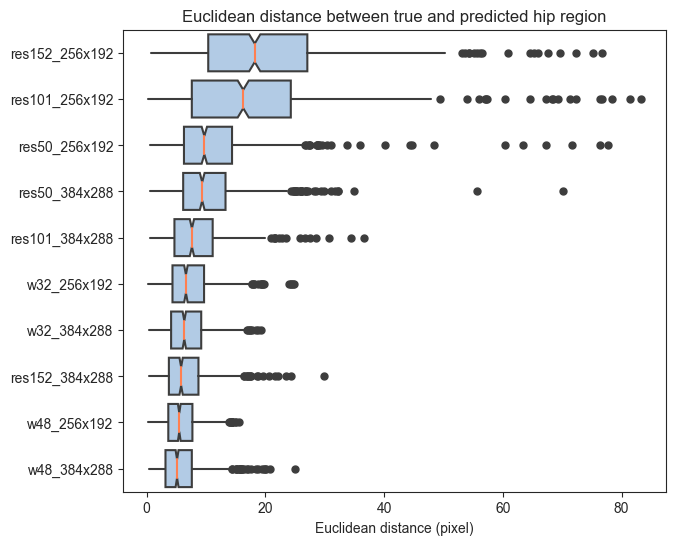

In [163]:
order = melt_all_model_df.groupby('model')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(7, 6))
sns.boxplot(
    data=melt_all_model_df, x="value", y="model",
    notch=True, showcaps=False,
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_model_hipregion_93.pdf", bbox_inches = 'tight')

### Use w48_384x288 as optimal model

In [161]:
subset_df = all_model_df[all_model_df['model'] == 'w48_384x288']

In [162]:
melt_subset_df = subset_df.melt(id_vars = 'model', value_vars = hip_regions); melt_subset_df

,model,variable,value
0,w48_384x288,iliac_crest_left,1.284217
1,w48_384x288,iliac_crest_left,7.694751
2,w48_384x288,iliac_crest_left,2.824609
3,w48_384x288,iliac_crest_left,5.99931
4,w48_384x288,iliac_crest_left,3.519831
...,...,...,...
777,w48_384x288,obturator_righ,3.105994
778,w48_384x288,obturator_righ,1.95805
779,w48_384x288,obturator_righ,6.701322
780,w48_384x288,obturator_righ,1.748631


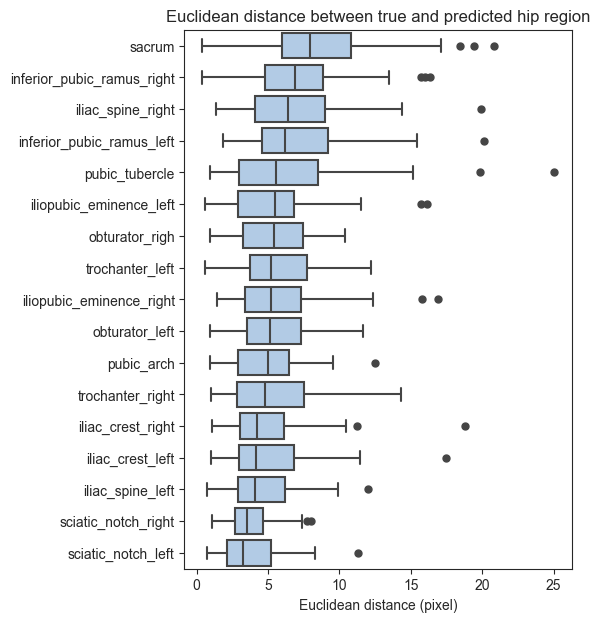

In [164]:
order = melt_subset_df.groupby('variable')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(5, 7))
sns.boxplot(
    data=melt_subset_df, x="value", y="variable",
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_hipregion_93.pdf", bbox_inches = 'tight')

## Fastai HRNet result

### analysis val res from fastai hrnet32

In [66]:
hrnet32 = json.load(open("out_fastai/val_res_hrnet32.json"))

In [67]:
val_both = json.load(open("annotation_images/trainval_both_17_cp.json"))

In [68]:
def get_fastai_val_kps(image_id):
    return hrnet32[image_id]

In [69]:
model_res = {"hrnet32": hrnet32}

hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_righ']

In [70]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [71]:
def get_true_val_kps(image_id):
    for i in range(len(val_both['annotations'])):
        if val_both['annotations'][i]['image_id'] == image_id:
            return np.array(val_both['annotations'][i]['keypoints']).reshape(-1, 3)[:, :-1]

In [72]:
all_model_df = pd.DataFrame(columns = hip_regions + ['model', 'image_id'])

for model_name, model in model_res.items():
    df = pd.DataFrame(columns = hip_regions)
    for i in range(len(list(hrnet32.keys()))):
        true_kps = get_true_val_kps(int(list(hrnet32.keys())[i]))
        val_kps = get_fastai_val_kps(list(hrnet32.keys())[i])
        for j in range(len(hip_regions)):
            ed = cal_euclidean_distance(true_kps[j][0], true_kps[j][1], val_kps[j][0], val_kps[j][1])
            df.loc[i, hip_regions[j]] = ed
        df.loc[i, 'image_id'] = "{:05d}".format(int(list(hrnet32.keys())[i]))
    df['model'] = model_name
    all_model_df = pd.concat([all_model_df, df])

In [73]:
all_model_df.head()

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ,model,image_id
0,0.497915,2.384777,2.104507,1.6117,3.29827,1.421717,4.66542,7.713501,0.351618,0.630368,1.352535,1.781145,1.27455,0.389158,1.080452,1.948783,1.851098,hrnet32,11768
1,1.74352,2.848597,1.335501,1.102447,0.404336,1.903232,3.45875,2.140327,0.204785,0.472814,0.826042,1.093425,0.935593,0.745975,1.190083,1.124393,1.811714,hrnet32,17469
2,1.280641,0.23764,0.921365,0.43376,1.399623,0.277411,0.522982,0.95985,0.704432,0.089295,0.466423,2.448287,0.499505,0.438422,0.380309,0.287819,0.283692,hrnet32,11975
3,0.776835,1.45948,0.587937,4.680132,0.816215,0.462958,2.217716,1.013718,0.637624,0.894037,1.494899,3.224828,1.520425,1.95026,0.698644,1.385972,0.971566,hrnet32,06676
4,0.614339,0.350955,3.105563,0.831308,0.986846,0.603491,1.06714,1.282016,0.923393,2.343042,0.572997,1.252148,1.060927,0.306384,0.245322,0.304302,0.244146,hrnet32,13613


In [75]:
all_model_df.to_csv("./results/pred_vs_anno_val.csv", index = False)

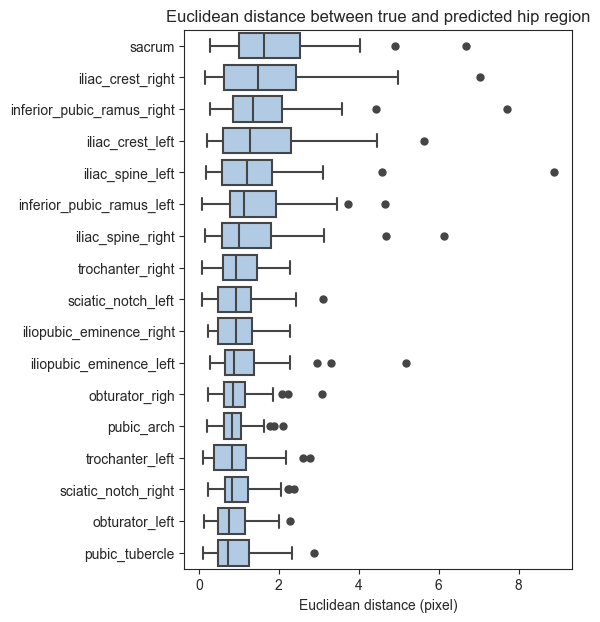

In [124]:
# test
melt_subset_df = all_model_df.melt(id_vars = 'model', value_vars = hip_regions)
order = melt_subset_df.groupby('variable')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(5, 7))
sns.boxplot(
    data=melt_subset_df, x="value", y="variable",
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
# plt.xlim(0, 7)
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/edistance_hipregion_cp_fastai.pdf", bbox_inches = 'tight')

#### look at outliers

In [118]:
hrnet32 = json.load(open("out_fastai/val_res_hrnet32.json"))
val_both = json.load(open("annotation_images/trainval_both_17_cp.json"))
pred_kps = hrnet32["949"][2]
true_kps = np.array([i for i in val_both['annotations'] if i['image_id'] == int("949")][0]['keypoints']).reshape(-1, 3)[:, :-1][2]

img = Image.open(os.path.join("annotation_images/82_93_central_crop/", '{:0>5}.jpg'.format("949")))
rgb_img = Image.new("RGBA", img.size)
rgb_img.paste(img)

draw = ImageDraw.Draw(rgb_img)

print(pred_kps)
print(true_kps)

x, y = pred_kps
draw.ellipse((x-2, y-2, x+2, y+2), fill=('red'))

x, y = true_kps
draw.ellipse((x-2, y-2, x+2, y+2), fill=('green'))

[67.60040283203125, 97.43744659423828]
[ 70 106]


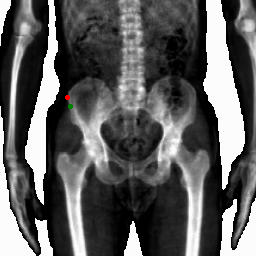

In [119]:
rgb_img

In [121]:
hrnet32 = json.load(open("out_fastai/val_res_hrnet32.json"))
val_both = json.load(open("annotation_images/trainval_both_17_cp.json"))
pred_kps = hrnet32["11768"][7]
true_kps = np.array([i for i in val_both['annotations'] if i['image_id'] == int("11768")][0]['keypoints']).reshape(-1, 3)[:, :-1][7]

img = Image.open(os.path.join("annotation_images/82_93_central_crop/", '{:0>5}.jpg'.format("11768")))
rgb_img = Image.new("RGBA", img.size)
rgb_img.paste(img)

draw = ImageDraw.Draw(rgb_img)

print(pred_kps)
print(true_kps)

x, y = pred_kps
draw.ellipse((x-2, y-2, x+2, y+2), fill=('red'))

x, y = true_kps
draw.ellipse((x-2, y-2, x+2, y+2), fill=('green'))

[152.88519287109375, 164.52261352539062]
[146 168]


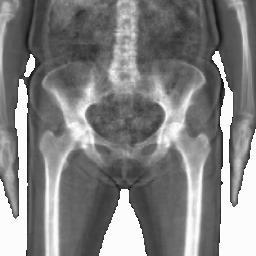

In [123]:
img

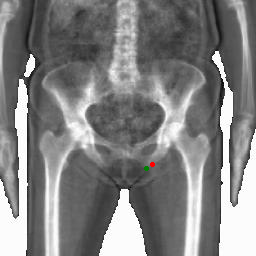

In [122]:
rgb_img

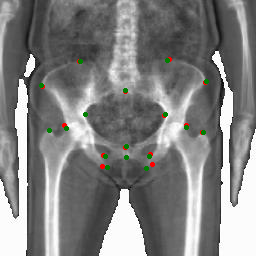

In [158]:
hrnet32 = json.load(open("out_fastai/val_res_hrnet32.json"))
val_both = json.load(open("annotation_images/trainval_both_17_cp.json"))
pred_kps = hrnet32["11768"]
true_kps = np.array([i for i in val_both['annotations'] if i['image_id'] == int("11768")][0]['keypoints']).reshape(-1, 3)[:, :-1]

img = Image.open(os.path.join("annotation_images/82_93_central_crop/", '{:0>5}.jpg'.format("11768")))
rgb_img = Image.new("RGBA", img.size)
rgb_img.paste(img)

draw = ImageDraw.Draw(rgb_img)

# print(pred_kps)
# print(true_kps)

for point in pred_kps:
    x, y = point
    draw.ellipse((x-2, y-2, x+2, y+2), fill=('red'))

for point in true_kps:
    x, y = point
    draw.ellipse((x-2, y-2, x+2, y+2), fill=('green'))
    
rgb_img

### Q: for every phenotype can you plot the error/variance of the phenotype

In [271]:
hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_right']

In [272]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [273]:
hrnet32 = json.load(open("out_fastai/val_res_hrnet32.json"))
val_both = json.load(open("annotation_images/trainval_both_17_cp.json"))

In [274]:
# get annotation phenotypes

columns = []

for i in range(len(hip_regions)):
    for j in range(i+1, len(hip_regions)):
        columns.append(hip_regions[i] + '2' + hip_regions[j])
        
index = [str(i['image_id']) for i in val_both['annotations']]

val_distance = pd.DataFrame(index = index, columns = columns)

for i in range(len(val_both['annotations'])):
    idx = str(val_both['annotations'][i]['image_id'])
    kps = np.array(val_both['annotations'][i]['keypoints']).reshape(-1, 3)[:, :-1]
    for m in range(len(hip_regions)):
        for n in range(m+1, len(hip_regions)):
            ed = cal_euclidean_distance(kps[m][0],
                                        kps[m][1],
                                        kps[n][0],
                                        kps[n][1])
            val_distance.loc[idx, hip_regions[m] + '2' + hip_regions[n]] = ed

In [275]:
# get prediction phenotypes

columns = []

for i in range(len(hip_regions)):
    for j in range(i+1, len(hip_regions)):
        columns.append(hip_regions[i] + '2' + hip_regions[j])
        
index = list(hrnet32.keys())

pred_distance = pd.DataFrame(index = index, columns = columns)

for i in range(len(list(hrnet32.keys()))):
    idx = list(hrnet32.keys())[i]
    kps = hrnet32[idx]
    for m in range(len(hip_regions)):
        for n in range(m+1, len(hip_regions)):
            ed = cal_euclidean_distance(kps[m][0],
                                        kps[m][1],
                                        kps[n][0],
                                        kps[n][1])
            pred_distance.loc[idx, hip_regions[m] + '2' + hip_regions[n]] = ed

In [276]:
pred_distance.head()

,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,iliac_crest_left2inferior_pubic_ramus_left,iliac_crest_left2inferior_pubic_ramus_right,iliac_crest_left2pubic_arch,iliac_crest_left2sciatic_notch_left,iliac_crest_left2sciatic_notch_right,...,pubic_tubercle2trochanter_left,pubic_tubercle2trochanter_right,pubic_tubercle2obturator_left,pubic_tubercle2obturator_right,trochanter_left2trochanter_right,trochanter_left2obturator_left,trochanter_left2obturator_right,trochanter_right2obturator_left,trochanter_right2obturator_right,obturator_left2obturator_right
11768,89.695039,44.570782,127.398241,65.486337,124.543281,107.550916,126.628292,106.710936,53.294366,100.8148,...,78.686714,77.660293,24.42891,25.725884,153.167984,59.617976,104.339914,101.829618,56.289537,47.467854
17469,74.148159,24.32639,97.819073,45.107946,95.527299,82.712457,102.045778,81.291915,38.649764,77.136987,...,57.956384,55.221437,25.816894,24.357889,112.78217,40.359139,79.834965,79.069001,39.978222,41.668814
11975,72.584503,28.000727,95.804404,51.440862,96.747306,90.14589,103.047038,85.405837,45.482243,76.212823,...,57.943377,56.681518,22.794338,21.310516,114.287631,45.600399,76.121665,75.892186,44.385906,32.867122
6676,93.310136,28.848719,113.072945,63.277209,112.789663,110.756482,126.000243,102.918056,51.882087,90.185861,...,67.019846,64.517778,27.51888,24.649118,130.54338,49.906541,89.40709,89.830471,49.410837,42.652131
13613,91.883098,31.527725,119.750988,68.226716,120.832302,113.609611,135.291441,112.95494,56.917437,100.53429,...,74.133351,74.756468,27.965108,28.061821,145.277118,51.131014,102.151092,102.700098,52.045961,53.89701


In [277]:
val_distance_filter = val_distance[val_distance.index.isin(pred_distance.index)]

In [278]:
val_distance_filter.shape

(58, 136)

In [279]:
columns = []

for i in range(len(hip_regions)):
    for j in range(i+1, len(hip_regions)):
        columns.append(hip_regions[i] + '2' + hip_regions[j])
        
index = list(hrnet32.keys())

distance_err = pd.DataFrame(index = index, columns = columns)

for idx in index:
    for col in columns:
        distance_err.loc[idx, col] = np.abs(val_distance_filter.loc[idx, col] -
                                            pred_distance.loc[idx, col])

In [280]:
distance_err.head()

,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,iliac_crest_left2inferior_pubic_ramus_left,iliac_crest_left2inferior_pubic_ramus_right,iliac_crest_left2pubic_arch,iliac_crest_left2sciatic_notch_left,iliac_crest_left2sciatic_notch_right,...,pubic_tubercle2trochanter_left,pubic_tubercle2trochanter_right,pubic_tubercle2obturator_left,pubic_tubercle2obturator_right,trochanter_left2trochanter_right,trochanter_left2obturator_left,trochanter_left2obturator_right,trochanter_right2obturator_left,trochanter_right2obturator_right,obturator_left2obturator_right
11768,2.689292,1.222231,0.179187,2.960723,0.324649,1.833727,0.910354,0.259069,0.05904,0.644944,...,0.041943,0.602086,1.169504,0.646012,0.845002,2.12342,1.015183,0.933632,2.80361,3.467854
17469,4.119594,1.63512,0.80361,0.723264,3.08813,0.67588,2.723071,1.667798,0.993424,2.250406,...,0.59274,0.787491,0.259915,1.012654,1.43254,1.830907,1.088537,0.360213,2.565872,2.617566
11975,1.442519,0.342093,0.885823,0.804907,0.889777,0.859604,1.576095,1.358211,0.398036,0.988213,...,0.628458,0.353559,0.12277,0.621196,0.217477,0.422971,0.161149,0.035411,0.001224,0.132878
6676,1.304702,0.849766,1.874923,0.675898,0.929288,1.252446,1.263263,0.952055,0.094058,0.877407,...,2.390131,0.25876,0.059819,0.795397,2.539474,2.398647,2.573916,0.690245,0.237929,0.394355
13613,0.116902,2.116842,0.231115,1.357765,1.204577,1.146653,0.499008,0.261667,2.765057,0.421146,...,0.391812,0.030301,0.072457,0.403187,0.190936,0.140818,0.03012,0.08431,0.074815,0.112249


#### get image_size info

In [16]:
dtypes = {"Image ID": object}
df_82 = pd.read_csv('./annotation_images/816_288_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
df_93 = pd.read_csv('./annotation_images/960_384_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
dict_82 = df_82[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()
dict_93 = df_93[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()

In [17]:
tv_both = json.load(open("annotation_images/trainval_both_17_cp.json"))
tv_82 = json.load(open("annotation_images/trainval_816_288_17_cp.json"))
tv_93 = json.load(open("annotation_images/trainval_960_384_17_cp.json"))

In [30]:
tv_ids = [i['id'] for i in tv_both['images']]
columns = ['image_id', 'image_size', 'file_name']
tv_mapping = pd.DataFrame(index = tv_ids, columns = columns)

for id in tv_ids:
    img_id = int(id)
    if img_id in [i['image_id'] for i in tv_82['annotations']]:
        image_size = '816x288'
    elif img_id in [i['image_id'] for i in tv_93['annotations']]:
        image_size = '960x384'
    else:
        print("Image not found")
        
    if image_size == '816x288':
        file_name = next(iter({k for k, v in dict_82.items() if int(v) == int(img_id)}))
    elif image_size == '960x384':
        file_name = next(iter({k for k, v in dict_93.items() if int(v) == int(img_id)}))
    
    tv_mapping.loc[img_id, 'image_id'] = img_id
    tv_mapping.loc[img_id, 'image_size'] = image_size
    tv_mapping.loc[img_id, 'file_name'] = file_name

In [34]:
len(set(tv_mapping['image_id'])) # -> output = 293, which means all image ids are unique, so for one image id, there is only one image size

293

In [38]:
tv_mapping[tv_mapping['image_id'] == 15931]['file_name'].values[0]

'1.2.840.113619.2.110.210419.20171109161505.1.12.12.1'

In [35]:
tv_mapping

,image_id,image_size,file_name
93,93,816x288,1.2.840.113619.2.110.210419.20180319173427.1.1...
157,157,816x288,1.2.840.113619.2.110.210419.20180323183139.1.1...
223,223,816x288,1.2.840.113619.2.110.210419.20180327185012.1.1...
579,579,816x288,1.2.840.113619.2.110.210419.20180423150508.1.1...
631,631,816x288,1.2.840.113619.2.110.210419.20180426194009.1.1...
...,...,...,...
15931,15931,960x384,1.2.840.113619.2.110.210419.20171109161505.1.1...
16295,16295,960x384,1.2.840.113619.2.110.210419.20171202095514.1.1...
16499,16499,960x384,1.2.840.113619.2.110.210419.20171217165033.1.1...
17087,17087,960x384,1.2.840.113619.2.110.210419.20180210085043.1.1...


In [32]:
tv_mapping['file_name'] = tv_mapping['file_name'].apply(lambda x: x[:-4])
tv_mapping.to_csv("annotation_images/tv_mapping.csv", index = False)

In [231]:
index = distance_err.index
columns = ['image_id', 'image_size', 'file_name']
val_mapping = pd.DataFrame(index = index, columns = columns)

for idx in index:
    img_id = int(idx)
    if img_id in [i['image_id'] for i in tv_82['annotations']]:
        image_size = '816x288'
    elif img_id in [i['image_id'] for i in tv_93['annotations']]:
        image_size = '960x384'
    else:
        print("Image not found")
        
    if image_size == '816x288':
        file_name = next(iter({k for k, v in dict_82.items() if int(v) == int(idx)}))
    elif image_size == '960x384':
        file_name = next(iter({k for k, v in dict_93.items() if int(v) == int(idx)}))
    
    val_mapping.loc[idx, 'image_id'] = img_id
    val_mapping.loc[idx, 'image_size'] = image_size
    val_mapping.loc[idx, 'file_name'] = file_name

In [241]:
val_mapping['file_name'] = val_mapping['file_name'].apply(lambda x: x[:-4])

In [260]:
val_mapping.to_csv("annotation_images/val_mapping.csv", index = False)

#### convert pixels to cm

In [261]:
val_mapping = pd.read_csv("annotation_images/val_mapping.csv"); val_mapping.head()

,image_id,image_size,file_name
0,11768,960x384,1.2.840.113619.2.110.210419.20170126131405.1.1...
1,17469,816x288,1.2.840.113619.2.110.212174.20180827105549.1.1...
2,11975,816x288,1.2.840.113619.2.110.212038.20180630151531.1.1...
3,6676,960x384,1.2.840.113619.2.110.210419.20160113170558.1.1...
4,13613,960x384,1.2.840.113619.2.110.210419.20170606161925.1.1...


In [243]:
p_all_info_z_filtered = pd.read_csv("all_prediction/p_all_info_z_filtered.csv")
p_all_info_z_filtered = p_all_info_z_filtered[['file_name', 'ratio']]; p_all_info_z_filtered.head()

,file_name,ratio
0,1.2.840.113619.2.110.210419.20160630134650.1.1...,0.212000
1,1.2.840.113619.2.110.212038.20190713145954.1.1...,0.269630
2,1.2.840.113619.2.110.210419.20180924120844.1.1...,0.269919
3,1.2.840.113619.2.110.210419.20170305174208.1.1...,0.213599
4,1.2.840.113619.2.110.212038.20190307144208.1.1...,0.278119


In [263]:
val_mapping['image_id'] = val_mapping['image_id'].apply(lambda x: str(x))

In [281]:
pred_distance = pred_distance.merge(val_mapping, left_index = True, right_on = 'image_id', how = 'inner')
pred_distance = pred_distance.merge(p_all_info_z_filtered, left_on = 'file_name', right_on = 'file_name', how = 'inner')

for i in range(len(hip_regions)):
    for j in range(i+1, len(hip_regions)):
        pred_distance[hip_regions[i] + '2' + hip_regions[j]] = pred_distance[hip_regions[i] + '2' + hip_regions[j]] * pred_distance['ratio']

In [282]:
pred_distance.head()

,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,iliac_crest_left2inferior_pubic_ramus_left,iliac_crest_left2inferior_pubic_ramus_right,iliac_crest_left2pubic_arch,iliac_crest_left2sciatic_notch_left,iliac_crest_left2sciatic_notch_right,...,trochanter_left2trochanter_right,trochanter_left2obturator_left,trochanter_left2obturator_right,trochanter_right2obturator_left,trochanter_right2obturator_right,obturator_left2obturator_right,image_id,image_size,file_name,ratio
0,18.952175,9.417614,26.918699,13.83698,26.315458,22.725045,26.756012,22.547561,11.26087,21.301732,...,32.363735,12.597021,22.046574,21.516159,11.893736,10.029753,11768,960x384,1.2.840.113619.2.110.210419.20170126131405.1.1...,0.211296
1,21.212407,6.959327,27.984214,12.904543,27.328581,23.662493,29.193396,23.256103,11.056978,22.067455,...,32.264878,11.545998,22.839296,22.620168,11.437025,11.920672,17469,816x288,1.2.840.113619.2.110.212174.20180827105549.1.1...,0.286081
2,19.733912,7.612698,26.046822,13.985484,26.303174,24.508414,28.015914,23.219712,12.365485,20.720361,...,31.07195,12.397608,20.695578,20.633188,12.067418,8.935749,11975,816x288,1.2.840.113619.2.110.212038.20180630151531.1.1...,0.271875
3,20.510344,6.341188,24.854373,13.908857,24.792106,24.345196,27.695901,22.622244,11.404114,19.823602,...,28.69452,10.969873,19.652422,19.745484,10.860913,9.375293,6676,960x384,1.2.840.113619.2.110.210419.20160113170558.1.1...,0.219808
4,20.187563,6.926932,26.310396,14.990038,26.54797,24.961078,29.724776,24.817241,12.505285,22.08831,...,31.918721,11.233955,22.443536,22.564158,11.434977,11.84167,13613,960x384,1.2.840.113619.2.110.210419.20170606161925.1.1...,0.219709


In [283]:
val_distance = val_distance.merge(val_mapping, left_index = True, right_on = 'image_id', how = 'inner')
val_distance = val_distance.merge(p_all_info_z_filtered, left_on = 'file_name', right_on = 'file_name', how = 'inner')

for i in range(len(hip_regions)):
    for j in range(i+1, len(hip_regions)):
        val_distance[hip_regions[i] + '2' + hip_regions[j]] = val_distance[hip_regions[i] + '2' + hip_regions[j]] * val_distance['ratio']

In [284]:
val_distance.head()

,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,iliac_crest_left2inferior_pubic_ramus_left,iliac_crest_left2inferior_pubic_ramus_right,iliac_crest_left2pubic_arch,iliac_crest_left2sciatic_notch_left,iliac_crest_left2sciatic_notch_right,...,trochanter_left2trochanter_right,trochanter_left2obturator_left,trochanter_left2obturator_right,trochanter_right2obturator_left,trochanter_right2obturator_right,obturator_left2obturator_right,image_id,image_size,file_name,ratio
0,18.331512,7.873428,24.797061,16.02364,25.449366,25.700846,29.195765,24.580708,12.178979,20.335062,...,31.27605,11.45323,21.118712,21.776076,12.178979,10.24408,93,816x288,1.2.840.113619.2.110.210419.20180319173427.1.1...,0.269581
1,15.751329,8.151764,23.126937,13.700396,23.583252,23.185859,26.781446,22.599514,10.376853,18.532855,...,29.063562,10.447685,20.418729,20.295549,10.204849,10.591411,157,816x288,1.2.840.113619.2.110.210419.20180323183139.1.1...,0.271575
2,18.228502,6.443316,24.042711,13.060302,24.846571,22.834005,27.077372,22.1225,11.037014,20.202606,...,30.712821,11.183294,21.641427,21.227858,10.459689,11.15684,579,816x288,1.2.840.113619.2.110.210419.20180423150508.1.1...,0.271795
3,19.19714,7.181697,25.577391,14.547079,25.905211,25.558898,29.673475,24.244299,12.327448,20.273474,...,30.284963,11.980294,20.393325,20.364768,12.077058,8.937275,631,816x288,1.2.840.113619.2.110.210419.20180426194009.1.1...,0.269714
4,19.240618,7.749867,25.61756,12.781523,24.507231,24.251234,26.556221,23.032258,11.172286,19.468236,...,26.556221,10.318144,17.493691,18.427799,11.030085,7.862735,1900,816x288,1.2.840.113619.2.110.210419.20180721193414.1.1...,0.270968


In [287]:
set(pred_distance['image_id']) == set(val_distance['image_id'])

True

In [288]:
distance_err = distance_err.merge(val_mapping, left_index = True, right_on = 'image_id', how = 'inner')
distance_err = distance_err.merge(p_all_info_z_filtered, left_on = 'file_name', right_on = 'file_name', how = 'inner')

for i in range(len(hip_regions)):
    for j in range(i+1, len(hip_regions)):
        distance_err[hip_regions[i] + '2' + hip_regions[j]] = distance_err[hip_regions[i] + '2' + hip_regions[j]] * distance_err['ratio']

In [289]:
distance_err.head()

,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,iliac_crest_left2inferior_pubic_ramus_left,iliac_crest_left2inferior_pubic_ramus_right,iliac_crest_left2pubic_arch,iliac_crest_left2sciatic_notch_left,iliac_crest_left2sciatic_notch_right,...,trochanter_left2trochanter_right,trochanter_left2obturator_left,trochanter_left2obturator_right,trochanter_right2obturator_left,trochanter_right2obturator_right,obturator_left2obturator_right,image_id,image_size,file_name,ratio
0,0.568236,0.258252,0.037861,0.625588,0.068597,0.387459,0.192354,0.05474,0.012475,0.136274,...,0.178545,0.448669,0.214504,0.197272,0.592391,0.732742,11768,960x384,1.2.840.113619.2.110.210419.20170126131405.1.1...,0.211296
1,1.178539,0.467777,0.229898,0.206912,0.883456,0.193357,0.77902,0.477126,0.2842,0.643799,...,0.409823,0.523788,0.31141,0.10305,0.734048,0.748837,17469,816x288,1.2.840.113619.2.110.212174.20180827105549.1.1...,0.286081
2,0.392185,0.093007,0.240833,0.218834,0.241908,0.233705,0.428501,0.369264,0.108216,0.268671,...,0.059126,0.114995,0.043812,0.009627,0.000333,0.036126,11975,816x288,1.2.840.113619.2.110.212038.20180630151531.1.1...,0.271875
3,0.286784,0.186786,0.412124,0.148568,0.204265,0.275298,0.277676,0.20927,0.020675,0.192861,...,0.558197,0.527242,0.565768,0.151722,0.052299,0.086683,6676,960x384,1.2.840.113619.2.110.210419.20160113170558.1.1...,0.219808
4,0.025685,0.46509,0.050778,0.298313,0.264657,0.25193,0.109637,0.057491,0.607508,0.09253,...,0.04195,0.030939,0.006618,0.018524,0.016438,0.024662,13613,960x384,1.2.840.113619.2.110.210419.20170606161925.1.1...,0.219709


In [292]:
distance_err.iloc[:, :136].mean(axis = 0)

iliac_crest_left2iliac_crest_right           0.671042
iliac_crest_left2iliac_spine_left            0.340647
iliac_crest_left2iliac_spine_right           0.378532
iliac_crest_left2iliopubic_eminence_left     0.223757
iliac_crest_left2iliopubic_eminence_right    0.348483
                                               ...   
trochanter_left2obturator_left               0.250426
trochanter_left2obturator_right              0.250084
trochanter_right2obturator_left              0.233590
trochanter_right2obturator_right             0.245543
obturator_left2obturator_right               0.238123
Length: 136, dtype: float64

In [314]:
err = pd.DataFrame(distance_err.iloc[:, :136].mean(axis = 0), columns = ['error']);err.head()

,error
iliac_crest_left2iliac_crest_right,0.671042
iliac_crest_left2iliac_spine_left,0.340647
iliac_crest_left2iliac_spine_right,0.378532
iliac_crest_left2iliopubic_eminence_left,0.223757
iliac_crest_left2iliopubic_eminence_right,0.348483


Text(0.5, 0, 'Error (cm)')

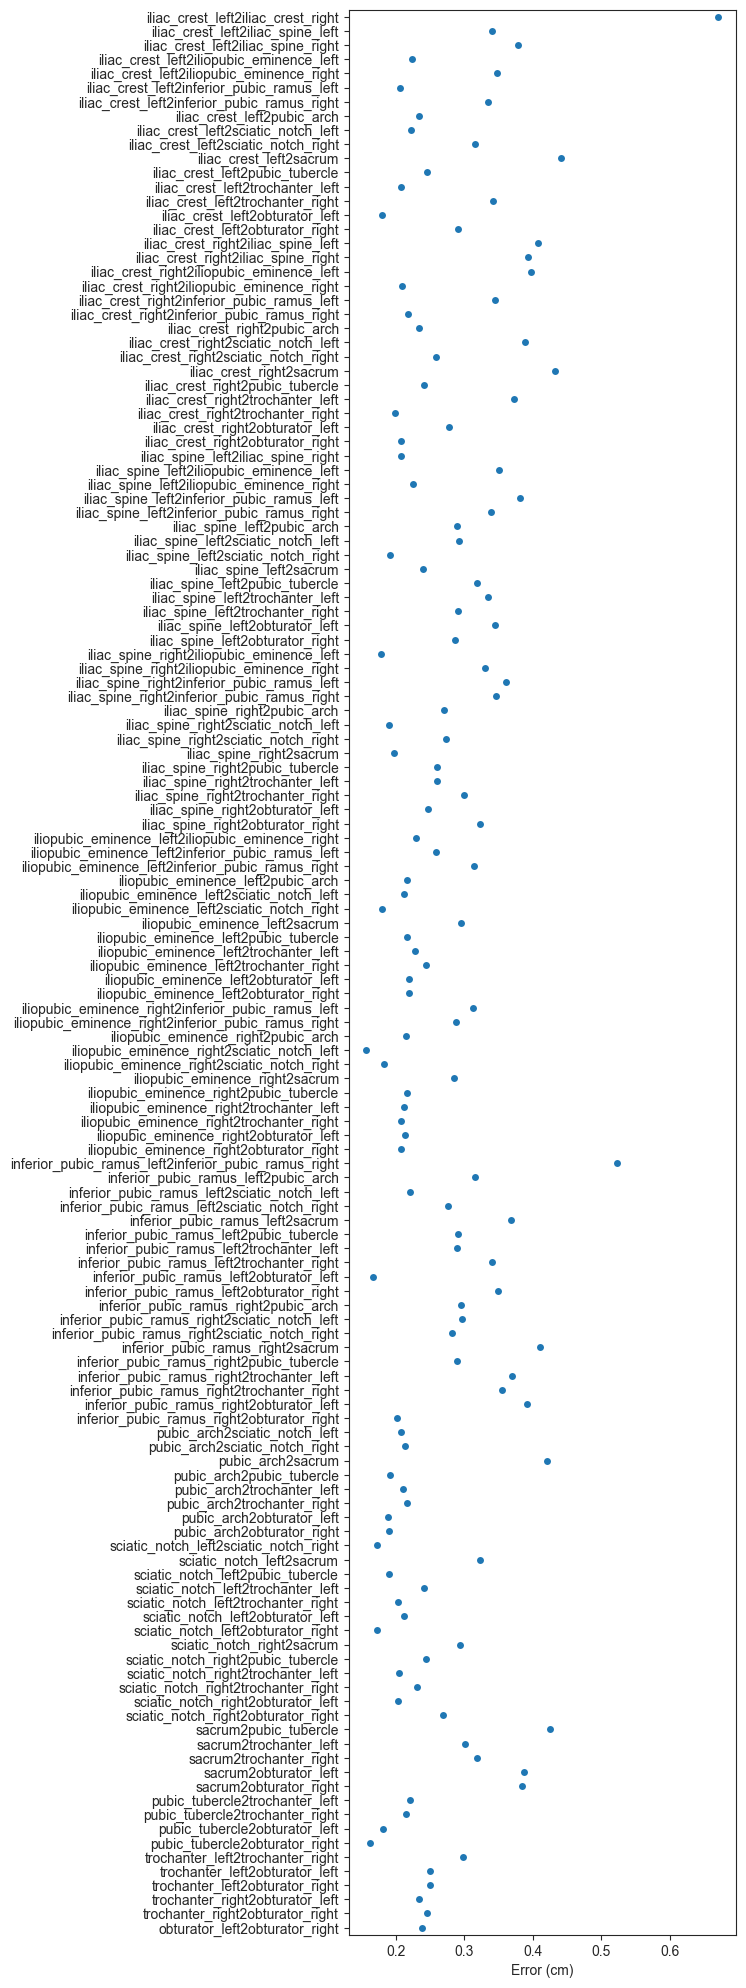

In [316]:
plt.figure(figsize = (5, 25))
sns.stripplot(x = err['error'],
              y = err.index)
plt.xlabel("Error (cm)")

In [313]:
pred_distance.iloc[:, :136].std(axis = 0)

iliac_crest_left2iliac_crest_right           1.183599
iliac_crest_left2iliac_spine_left            1.016232
iliac_crest_left2iliac_spine_right           1.356713
iliac_crest_left2iliopubic_eminence_left     0.895649
iliac_crest_left2iliopubic_eminence_right    1.210020
                                               ...   
trochanter_left2obturator_left               0.923059
trochanter_left2obturator_right              1.088799
trochanter_right2obturator_left              1.109390
trochanter_right2obturator_right             0.966910
obturator_left2obturator_right               1.107556
Length: 136, dtype: float64

In [309]:
mean_d_var = pd.DataFrame(distance_err.iloc[:, :136].mean(axis = 0) / pred_distance.iloc[:, :136].std(axis = 0),
                          columns = ['mean_err_divide_std'])

In [310]:
mean_d_var

,mean_err_divide_std
iliac_crest_left2iliac_crest_right,0.566950
iliac_crest_left2iliac_spine_left,0.335206
iliac_crest_left2iliac_spine_right,0.279007
iliac_crest_left2iliopubic_eminence_left,0.249827
iliac_crest_left2iliopubic_eminence_right,0.287998
...,...
trochanter_left2obturator_left,0.271300
trochanter_left2obturator_right,0.229688
trochanter_right2obturator_left,0.210557
trochanter_right2obturator_right,0.253946


<AxesSubplot:xlabel='mean_err_divide_std'>

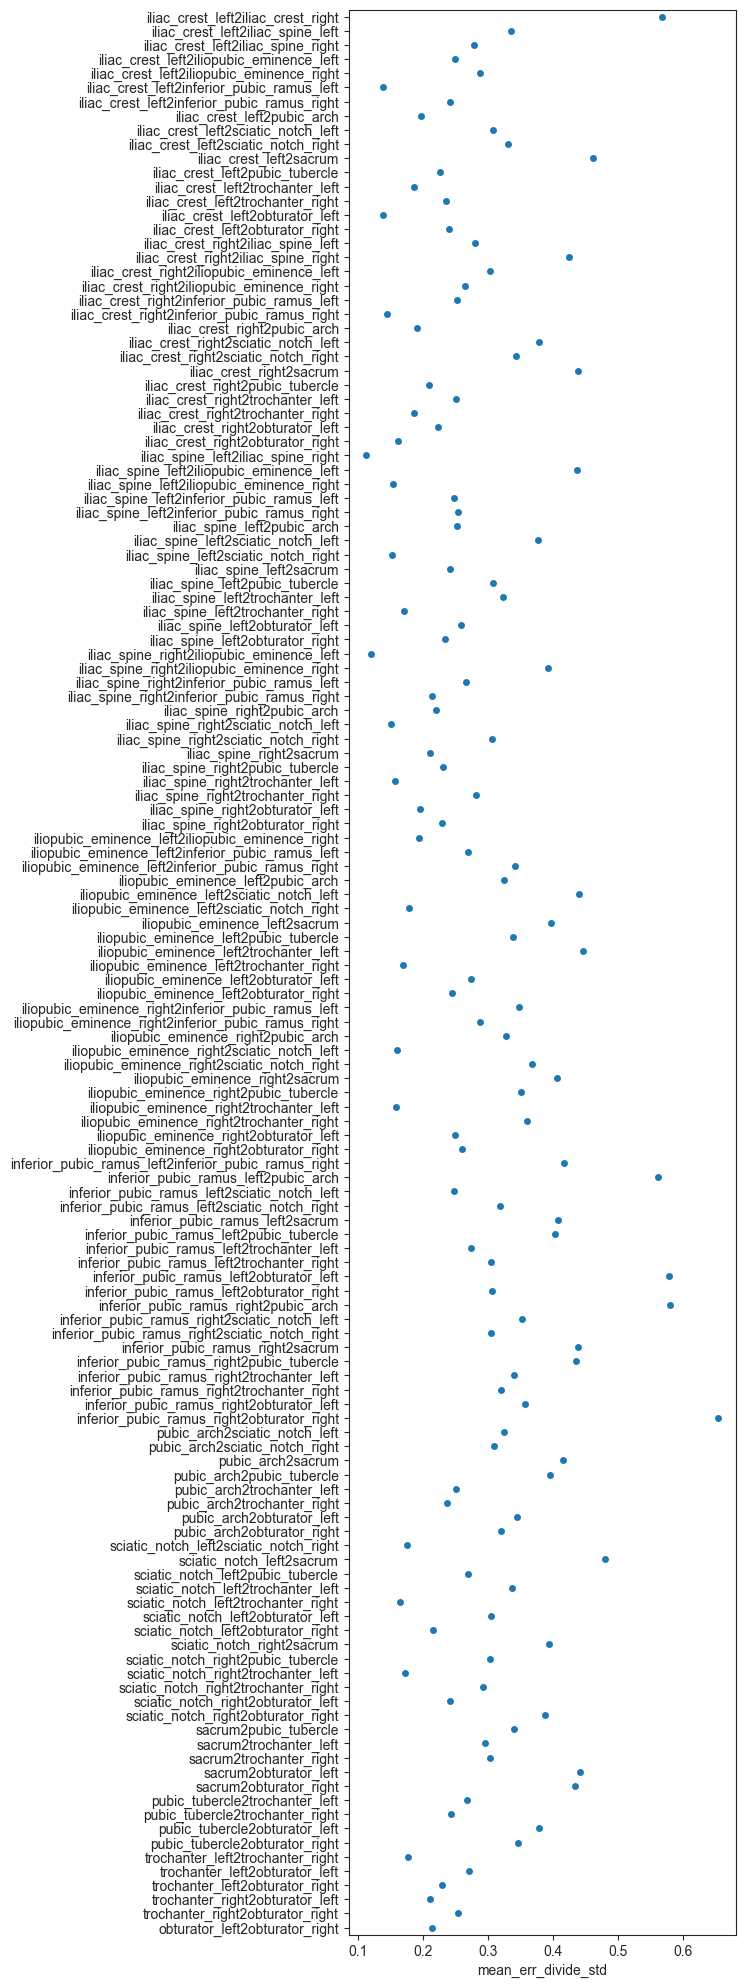

In [312]:
plt.figure(figsize = (5, 25))
sns.stripplot(x = mean_d_var['mean_err_divide_std'],
              y = mean_d_var.index)

### Use prediction as training set

Visually speaking, the model predictions looks better than human manually annotation, so we need to provide the evidence to support this claim. So we use prediction result as training set annotation and train the model again

In [127]:
# load data

# prediction result -- using prediction as train
val_res_p_as_t_same = json.load(open("all_prediction/val_res_pred_as_train_hrnet32_same.json"))
val_res_p_as_t = json.load(open("all_prediction/val_res_pred_as_train_hrnet32.json"))

# prediction result -- using human annotation as train
hrnet32_82_pred = json.load(open("all_prediction/hrnet32_82_pred.json"))
hrnet32_93_pred = json.load(open("all_prediction/hrnet32_93_pred.json"))

In [47]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

#### Use prediction as training set - same images as human annotation

In [46]:
[i for i in list(val_res_p_as_t_same.keys()) if i.split("_")[0] not in list(hrnet32_82_pred.keys()) and i.split("_")[0] not in list(hrnet32_93_pred.keys())]

[]

In [48]:
hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_righ']

In [52]:
val_name = sorted(list(val_res_p_as_t_same.keys()))

In [58]:
for i in val_name:
    print(i)

00048_93
00611_93
00646_93
00815_93
00847_82
00949_93
01432_93
01684_82
01698_93
01709_93
02192_82
02406_82
02760_93
02992_93
03268_93
03460_82
04255_82
04271_93
05022_82
05273_82
05658_82
05980_82
06742_82
07071_93
08582_82
08952_93
09322_82
09869_82
09948_82
10466_93
10999_93
11653_82
12009_93
12084_82
12443_93
12943_93
13220_93
13290_93
13338_93
13611_93
13693_93
14012_93
14241_93
14445_93
14654_82
14655_93
15089_93
15233_82
15313_93
15468_93
15611_93
15653_82
15803_82
17539_82
17600_82
19549_82
21227_82
21502_82


In [61]:
val_name = sorted(list(val_res_p_as_t_same.keys()))

error_df = pd.DataFrame(columns = hip_regions, index = val_name)

for image_name in val_name:
    img_id = image_name.split("_")[0]
    img_size = image_name.split("_")[1]
    if img_size == '82':
        pred_kps = hrnet32_82_pred[img_id]
    elif img_size == '93':
        pred_kps = hrnet32_93_pred[img_id]
    ppred_kps = val_res_p_as_t_same[image_name]
    for i in range(len(hip_regions)):
        error_df.loc[image_name, hip_regions[i]] = cal_euclidean_distance(pred_kps[i][0], 
                                                                          pred_kps[i][1], 
                                                                          ppred_kps[i][0], 
                                                                          ppred_kps[i][1])

In [63]:
error_df.head()

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ
00048_93,0.292693,0.562353,0.201118,0.808473,0.218007,0.241331,0.415028,0.329707,0.518248,0.373939,0.300433,0.425022,1.641313,0.332549,0.17528,0.22562,0.401063
00611_93,0.694778,0.766913,0.598526,0.244606,0.191612,0.250417,0.537934,0.351321,0.297756,0.153756,0.130682,0.823392,0.139834,0.242247,0.345507,0.127239,0.417886
00646_93,1.082685,2.363731,0.773579,0.334656,0.672791,0.595959,0.093157,0.592085,0.204523,0.321246,0.863985,0.404542,0.816468,0.429007,0.184426,0.234161,0.082632
00815_93,0.500967,1.847656,0.266197,0.304778,0.373317,0.336682,0.627767,0.773743,0.026094,0.41768,0.928857,1.166886,0.504328,0.09557,0.8209,0.258117,0.116919
00847_82,1.281207,0.631394,1.020114,0.313839,0.644969,0.186731,0.56355,0.902737,0.225717,0.360048,0.146248,1.106528,0.453151,0.23522,0.688354,0.509208,0.663053


In [76]:
error_df.to_csv("./results/ppred_vs_pred_val_same_img.csv", index = True)

In [64]:
error_df.melt()

,variable,value
0,iliac_crest_left,0.292693
1,iliac_crest_left,0.694778
2,iliac_crest_left,1.082685
3,iliac_crest_left,0.500967
4,iliac_crest_left,1.281207
...,...,...
981,obturator_righ,0.028008
982,obturator_righ,0.153071
983,obturator_righ,0.187506
984,obturator_righ,0.276362


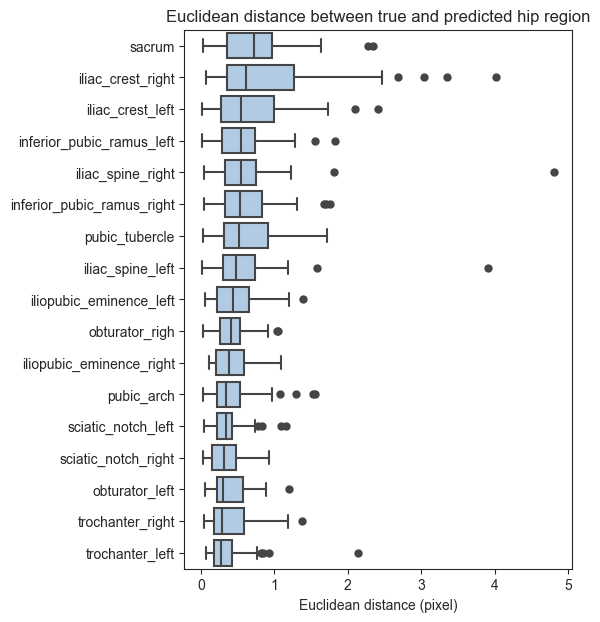

In [77]:
# plot error
melt_error_df = error_df.melt()
order = melt_error_df.groupby('variable')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(5, 7))
sns.boxplot(
    data=melt_error_df, x="value", y="variable",
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
# plt.xlim(0, 7)
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/ppred_vs_pred_val_same_img_ed.pdf", bbox_inches = 'tight')

#### Use prediction as training set - random sampled images

In [128]:
[i for i in list(val_res_p_as_t.keys()) if i.split("_")[0] not in list(hrnet32_82_pred.keys()) and i.split("_")[0] not in list(hrnet32_93_pred.keys())]

[]

In [ ]:
hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_righ']

In [129]:
val_name = sorted(list(val_res_p_as_t.keys()))

In [130]:
for i in val_name:
    print(i)

02491_82
02536_93
03246_93
03254_82
03342_82
03391_82
03401_82
03774_93
03797_93
04639_82
05693_82
06350_82
06705_82
07052_82
07283_93
07470_82
07543_93
07878_93
07914_82
08075_93
08480_82
08828_93
09022_93
09575_82
09730_93
10008_93
10049_82
10073_93
10297_82
10303_93
10403_93
11297_93
11409_82
11587_82
12699_93
12705_93
13360_82
13777_93
13807_93
13990_82
14772_93
14959_93
15436_82
15468_82
15712_93
15894_82
16279_93
16388_93
16746_82
17101_93
17118_82
17347_82
17390_82
17460_93
17808_82
18400_82
19073_82
20988_82


In [132]:
val_name = sorted(list(val_res_p_as_t.keys()))

error_df = pd.DataFrame(columns = hip_regions, index = val_name)

for image_name in val_name:
    img_id = image_name.split("_")[0]
    img_size = image_name.split("_")[1]
    if img_size == '82':
        pred_kps = hrnet32_82_pred[img_id]
    elif img_size == '93':
        pred_kps = hrnet32_93_pred[img_id]
    ppred_kps = val_res_p_as_t[image_name]
    for i in range(len(hip_regions)):
        error_df.loc[image_name, hip_regions[i]] = cal_euclidean_distance(pred_kps[i][0], 
                                                                          pred_kps[i][1], 
                                                                          ppred_kps[i][0], 
                                                                          ppred_kps[i][1])

In [133]:
error_df.head()

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ
02491_82,0.705131,0.868349,0.826663,0.176824,0.117286,0.44305,1.19541,1.109035,0.267854,0.316638,0.462409,0.893378,0.303891,0.278316,0.171981,0.378898,0.133664
02536_93,0.989244,0.499588,0.268088,0.174322,0.091243,0.745594,0.23321,0.310172,0.620319,0.69841,1.362619,1.381073,0.49761,0.219675,0.364471,0.3965,0.80167
03246_93,0.399757,1.199382,0.241657,0.370424,0.347292,0.222322,1.453968,2.131094,1.113335,0.063931,0.206841,3.366353,0.182821,0.373293,0.400116,0.300278,0.190555
03254_82,0.090717,0.178659,0.39195,0.902733,0.095027,0.505224,0.319289,0.522572,0.358089,0.286518,0.212378,0.437843,0.530663,0.21411,0.469889,0.347286,0.354786
03342_82,1.37524,0.982529,0.280039,0.295361,0.308487,0.443779,0.645506,1.773709,0.85501,0.503811,0.598176,1.015553,0.591494,0.601057,0.050796,0.562628,0.630209


In [134]:
error_df.to_csv("./results/ppred_vs_pred_val.csv", index = True)

In [135]:
error_df.melt()

,variable,value
0,iliac_crest_left,0.705131
1,iliac_crest_left,0.989244
2,iliac_crest_left,0.399757
3,iliac_crest_left,0.090717
4,iliac_crest_left,1.37524
...,...,...
981,obturator_righ,0.15791
982,obturator_righ,0.633025
983,obturator_righ,0.166141
984,obturator_righ,0.322678


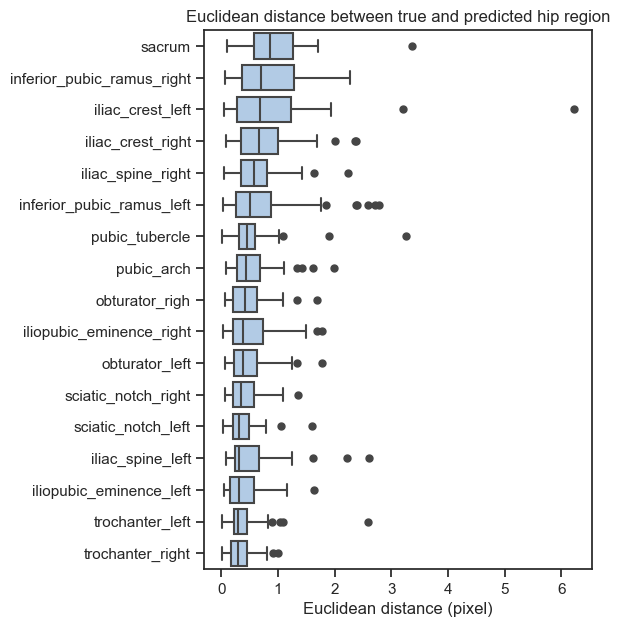

In [136]:
# plot error
melt_error_df = error_df.melt()
order = melt_error_df.groupby('variable')['value'].median().sort_values(ascending = False).index
sns.set_style("ticks")
plt.figure(figsize=(5, 7))
sns.boxplot(
    data=melt_error_df, x="value", y="variable",
    order=order,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
# plt.xlim(0, 7)
plt.title("Euclidean distance between true and predicted hip region")
plt.savefig("./results/ppred_vs_pred_val_ed.pdf", bbox_inches = 'tight')

### Training log

In [1]:
pwd

'/Users/alexxu/Library/CloudStorage/Box-Box/Narasimhan_lab/hip_shape'

In [4]:
panno = pd.read_clipboard()
panno.to_csv('key_results/pred_on_anno_training_log.csv', index=False)

In [8]:
ppred = pd.read_clipboard()
ppred.to_csv('key_results/pred_on_pred_training_log.csv', index=False)

In [37]:
panno['Type'] = 'predict on manual annotation'
ppred['Type'] = 'predict on 1st round prediction result'

# concat
pall = pd.concat([panno, ppred], axis=0)
pall_melt = pall.melt(id_vars=['epoch', 'nmae_topk', 'Type'], value_vars=['train_loss', 'valid_loss'], var_name='Dataset', value_name='Loss')

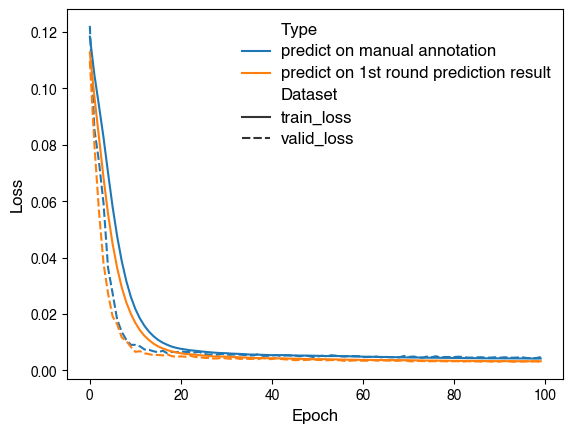

In [42]:
sns.lineplot(x="epoch", y="Loss", data=pall_melt, hue='Type', style = 'Dataset')
plt.xlabel('Epoch', fontname="Helvetica", fontsize=12)
plt.ylabel('Loss', fontname="Helvetica", fontsize=12)
plt.legend(frameon=False)

# Setting font for the tick labels
plt.xticks(fontname="Helvetica", fontsize=10)
plt.yticks(fontname="Helvetica", fontsize=10)

# Setting font for legend
legend = plt.legend(frameon=False)
for text in legend.get_texts():
    text.set_fontname('Helvetica')
    text.set_fontsize(12)

plt.savefig('out_fig/training_log.pdf', bbox_inches='tight')

### compare to human annotation

In [137]:
hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_righ']

In [138]:
ppred = pd.read_csv("./results/ppred_vs_pred_val.csv", index_col=0); ppred.head()

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ
02491_82,0.705131,0.868349,0.826663,0.176824,0.117286,0.443050,1.195410,1.109035,0.267854,0.316638,0.462409,0.893378,0.303891,0.278316,0.171981,0.378898,0.133664
02536_93,0.989244,0.499588,0.268088,0.174322,0.091243,0.745594,0.233210,0.310172,0.620319,0.698410,1.362619,1.381073,0.497610,0.219675,0.364471,0.396500,0.801670
03246_93,0.399757,1.199382,0.241657,0.370424,0.347292,0.222322,1.453968,2.131094,1.113335,0.063931,0.206841,3.366353,0.182821,0.373293,0.400116,0.300278,0.190555
03254_82,0.090717,0.178659,0.391950,0.902733,0.095027,0.505224,0.319289,0.522572,0.358089,0.286518,0.212378,0.437843,0.530663,0.214110,0.469889,0.347286,0.354786
03342_82,1.375240,0.982529,0.280039,0.295361,0.308487,0.443779,0.645506,1.773709,0.855010,0.503811,0.598176,1.015553,0.591494,0.601057,0.050796,0.562628,0.630209


In [140]:
ppred_same = pd.read_csv("./results/ppred_vs_pred_val_same_img.csv", index_col=0); ppred_same.head()

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ
00048_93,0.292693,0.562353,0.201118,0.808473,0.218007,0.241331,0.415028,0.329707,0.518248,0.373939,0.300433,0.425022,1.641313,0.332549,0.175280,0.225620,0.401063
00611_93,0.694778,0.766913,0.598526,0.244606,0.191612,0.250417,0.537934,0.351321,0.297756,0.153756,0.130682,0.823392,0.139834,0.242247,0.345507,0.127239,0.417886
00646_93,1.082685,2.363731,0.773579,0.334656,0.672791,0.595959,0.093157,0.592085,0.204523,0.321246,0.863985,0.404542,0.816468,0.429007,0.184426,0.234161,0.082632
00815_93,0.500967,1.847656,0.266197,0.304778,0.373317,0.336682,0.627767,0.773743,0.026094,0.417680,0.928857,1.166886,0.504328,0.095570,0.820900,0.258117,0.116919
00847_82,1.281207,0.631394,1.020114,0.313839,0.644969,0.186731,0.563550,0.902737,0.225717,0.360048,0.146248,1.106528,0.453151,0.235220,0.688354,0.509208,0.663053


In [141]:
h_anno = pd.read_csv("./results/pred_vs_anno_val.csv")[hip_regions]; h_anno.head()

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,sciatic_notch_right,sacrum,pubic_tubercle,trochanter_left,trochanter_right,obturator_left,obturator_righ
0,0.497915,2.384777,2.104507,1.611700,3.298270,1.421717,4.665420,7.713501,0.351618,0.630368,1.352535,1.781145,1.274550,0.389158,1.080452,1.948783,1.851098
1,1.743520,2.848597,1.335501,1.102447,0.404336,1.903232,3.458750,2.140327,0.204785,0.472814,0.826042,1.093425,0.935593,0.745975,1.190083,1.124393,1.811714
2,1.280641,0.237640,0.921365,0.433760,1.399623,0.277411,0.522982,0.959850,0.704432,0.089295,0.466423,2.448287,0.499505,0.438422,0.380309,0.287819,0.283692
3,0.776835,1.459480,0.587937,4.680132,0.816215,0.462958,2.217716,1.013718,0.637624,0.894037,1.494899,3.224828,1.520425,1.950260,0.698644,1.385972,0.971566
4,0.614339,0.350955,3.105563,0.831308,0.986846,0.603491,1.067140,1.282016,0.923393,2.343042,0.572997,1.252148,1.060927,0.306384,0.245322,0.304302,0.244146


In [144]:
ppred_melt = ppred.melt()
ppred_melt['source'] = 'pred_on_pred'

In [145]:
ppred_melt.head()

,variable,value,source
0,iliac_crest_left,0.705131,pred_on_pred
1,iliac_crest_left,0.989244,pred_on_pred
2,iliac_crest_left,0.399757,pred_on_pred
3,iliac_crest_left,0.090717,pred_on_pred
4,iliac_crest_left,1.375240,pred_on_pred


In [142]:
ppred_same_melt = ppred_same.melt()
ppred_same_melt['source'] = 'pred_on_pred_same_img'

In [143]:
ppred_same_melt.head()

,variable,value,source
0,iliac_crest_left,0.292693,pred_on_pred_same_img
1,iliac_crest_left,0.694778,pred_on_pred_same_img
2,iliac_crest_left,1.082685,pred_on_pred_same_img
3,iliac_crest_left,0.500967,pred_on_pred_same_img
4,iliac_crest_left,1.281207,pred_on_pred_same_img


In [146]:
h_anno_melt = h_anno.melt()
h_anno_melt['source'] = 'pred_on_anno'

In [147]:
h_anno_melt.head()

,variable,value,source
0,iliac_crest_left,0.497915,pred_on_anno
1,iliac_crest_left,1.743520,pred_on_anno
2,iliac_crest_left,1.280641,pred_on_anno
3,iliac_crest_left,0.776835,pred_on_anno
4,iliac_crest_left,0.614339,pred_on_anno


In [148]:
all_melt = pd.concat([ppred_melt, ppred_same_melt, h_anno_melt], axis = 0); all_melt.head()

,variable,value,source
0,iliac_crest_left,0.705131,pred_on_pred
1,iliac_crest_left,0.989244,pred_on_pred
2,iliac_crest_left,0.399757,pred_on_pred
3,iliac_crest_left,0.090717,pred_on_pred
4,iliac_crest_left,1.375240,pred_on_pred


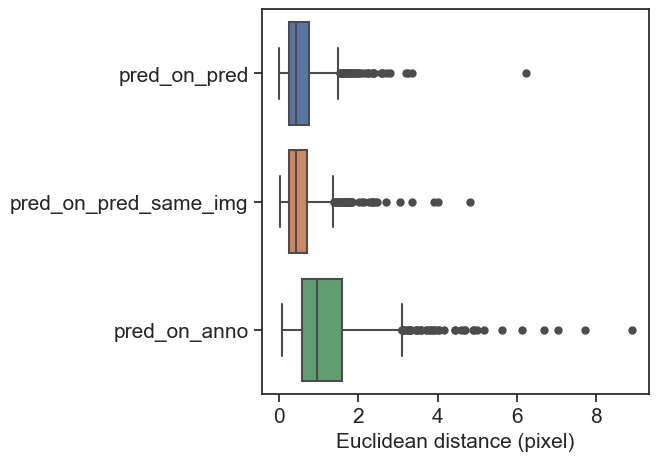

In [152]:
# overall error comparison
sns.set_theme(style="ticks")
# p = stats.ttest_ind(ppred_melt['value'].tolist(), h_anno_melt['value'].tolist())[1]
sns.set_style("ticks")
plt.figure(figsize=(5, 5))
sns.boxplot(x = "value", y = "source", data = all_melt, 
            flierprops={"marker": "o"})
plt.xlabel("Euclidean distance (pixel)", size = 15)
plt.ylabel("")
# plt.ylim(-1, 11)
plt.xticks(size = 15)
plt.yticks(size = 15)
# plt.text(x = 0.1, y = 10, s = "p-value = {:.3e}".format(p), fontsize = 15)
plt.savefig("./results/ppred_vs_pred.pdf", bbox_inches = 'tight')

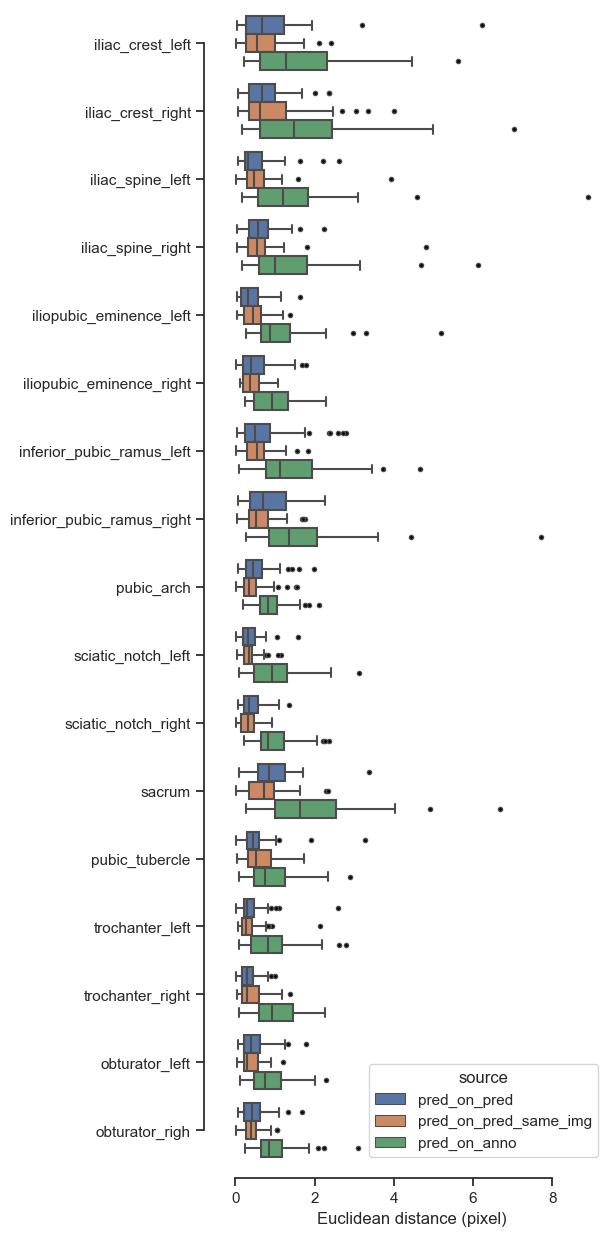

In [153]:
plt.figure(figsize=(5, 15))
sns.boxplot(x="value", y="variable",
            hue="source",
            flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 3},
            data=all_melt)
sns.despine(offset=10, trim=True)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")
plt.savefig("./results/ppred_vs_pred_split_ed.pdf", bbox_inches = 'tight')

### prediction vs human annotation (2023-07-16)

In [7]:
# copy paste from tacc jupyter notebook

val_set = """[Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11276_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/06157_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/08221_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01460_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/13299_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/00157_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/15233_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/12106_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11703_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/10377_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/09968_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/10466_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/20068_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01061_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/14914_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/00631_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/18529_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/07237_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11768_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01643_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/02957_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/03145_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/16212_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/21017_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/20181_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/03368_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/09869_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/14445_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/04809_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/14326_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/18085_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/07398_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/15653_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/00093_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/13666_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/14654_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/04549_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01698_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/10770_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/06770_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/07887_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01809_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/06938_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01432_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/04054_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/16295_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11380_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/12084_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/08760_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/02406_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/03268_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01729_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/14442_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/12443_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/15803_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/05565_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/13290_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11910_82.jpg')]"""

In [8]:
import re

# Regular expression pattern
pattern = r'(\d{5}_\d{2})'

# Find all matches
val_set = re.findall(pattern, val_set)

# Now 'matches' is a list of all "11276_93" like patterns
print(val_set)

['11276_93', '06157_93', '08221_93', '01460_82', '13299_82', '00157_82', '15233_82', '12106_82', '11703_82', '10377_82', '09968_82', '10466_93', '20068_82', '01061_82', '14914_93', '00631_82', '18529_82', '07237_93', '11768_93', '01643_82', '02957_82', '03145_93', '16212_82', '21017_82', '20181_82', '03368_93', '09869_82', '14445_93', '04809_93', '14326_82', '18085_82', '07398_82', '15653_82', '00093_82', '13666_93', '14654_82', '04549_93', '01698_93', '10770_82', '06770_93', '07887_82', '01809_93', '06938_93', '01432_93', '04054_93', '16295_93', '11380_82', '12084_82', '08760_93', '02406_82', '03268_93', '01729_93', '14442_82', '12443_93', '15803_82', '05565_93', '13290_93', '11910_82']


In [9]:
len(val_set)

58

#### Coordinates for annotation

In [11]:
# generate annotation keypoints
anno_path = "annotation_images/annotations/"

# mapping dict
dtypes = {"Image ID": object}
df_82 = pd.read_csv(anno_path + '816_288_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
df_93 = pd.read_csv(anno_path + '960_384_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
dict_82 = df_82[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()
dict_93 = df_93[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()

# load coco annotation result
anno_82 = json.load(open(os.path.join(anno_path, "tv_82_23kps.json")))
anno_93 = json.load(open(os.path.join(anno_path, "tv_93_23kps.json")))

# convert coco result to keypoints
anno_23kps = {}

for img in anno_82['images']:
    img_id = img['id']
    file_name = img['file_name']
    image_id = dict_82[file_name]
    for i in anno_82['annotations']:
        if i['image_id'] == img_id:
            kps = np.array(i['keypoints']).reshape(-1, 3)[:, :2]
            # according to central crop, adjust x,y
            kps[:, 0] = kps[:, 0] - 16
            kps[:, 1] = kps[:, 1] - 230
            kps = kps.tolist()
    anno_23kps[image_id  + '_82'] = kps

for img in anno_93['images']:
    img_id = img['id']
    file_name = img['file_name']
    image_id = dict_93[file_name]
    for i in anno_93['annotations']:
        if i['image_id'] == img_id:
            kps = np.array(i['keypoints']).reshape(-1, 3)[:, :2]
            # according to central crop, adjust x,y
            kps[:, 0] = kps[:, 0] - 64
            kps[:, 1] = kps[:, 1] - 302
            kps = kps.tolist()
    anno_23kps[image_id  + '_93'] = kps

In [12]:
len(anno_23kps['00093_82'])

23

In [13]:
len(anno_23kps.keys())

293

#### Coordinates for 1st and 2nd prediction

In [3]:
panno = json.load(open("all_prediction/all_res_pred_on_anno_23.json"))
ppred = json.load(open("all_prediction/all_res_pred_on_pred_23.json"))

In [4]:
len(panno['15666_82'])

23

#### Calculate euclidean distance

In [5]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [21]:
# hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 
#                'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 
#                'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_right', 
#                'sacrum_left', 'sacrum_right', 'inferior_iliac_spine_left', 'inferior_iliac_spine_right','acetabular_inferior_left', 'acetabular_inferior_right']

# select hip regions
hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right',
         'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum',
         'pubic_tubercle', 'inferior_iliac_spine_left', 'inferior_iliac_spine_right', 'acetabular_inferior_left', 'acetabular_inferior_right']

err_anno_vs_pred = pd.DataFrame(index = val_set, columns = hip_regions)

for key in val_set:
    for i in range(len(hip_regions)):
        err_anno_vs_pred.loc[key, hip_regions[i]] = cal_euclidean_distance(panno[key][i][0], panno[key][i][1], anno_23kps[key][i][0], anno_23kps[key][i][1])

err_anno_vs_pred = err_anno_vs_pred.reset_index()
err_anno_vs_pred = err_anno_vs_pred.melt(id_vars = 'index', var_name = 'hip_region', value_name = 'error')
err_anno_vs_pred['group'] = 'anno_vs_pred'

err_pred_vs_pred = pd.DataFrame(index = val_set, columns = hip_regions)

for key in val_set:
    for i in range(len(hip_regions)):
        err_pred_vs_pred.loc[key, hip_regions[i]] = cal_euclidean_distance(ppred[key][i][0], ppred[key][i][1], panno[key][i][0], panno[key][i][1])


err_pred_vs_pred = err_pred_vs_pred.reset_index()
err_pred_vs_pred = err_pred_vs_pred.melt(id_vars = 'index', var_name = 'hip_region', value_name = 'error')
err_pred_vs_pred['group'] = 'pred_vs_pred'

err = pd.concat([err_anno_vs_pred, err_pred_vs_pred], axis = 0)

# Mapping from old names to new names
name_mapping = {
    'iliac_crest_left': 'Iliac crest posterior right', 
    'iliac_crest_right': 'Iliac crest posterior left', 
    'iliac_spine_left': 'Iliac crest anterolateral right',
    'iliac_spine_right': 'Iliac crest anterolateral left',
    'iliopubic_eminence_left': 'Acetabulum posterosuperior right',
    'iliopubic_eminence_right': 'Acetabulum posterosuperior left', 
    'inferior_pubic_ramus_left': 'Ischiopubic ramus inferior right',
    'inferior_pubic_ramus_right': 'Ischiopubic ramus inferior left', 
    'pubic_arch': 'Pubic symphysis inferior', 
    'sciatic_notch_left': 'Pelvic inlet right',
    'sciatic_notch_right': 'Pelvic inlet left', 
    'sacrum': 'Sacrum midline', 
    'pubic_tubercle': 'Pubic symphysis superior', 
    'inferior_iliac_spine_left': 'Iliac body lateral right',
    'inferior_iliac_spine_right': 'Iliac body lateral left', 
    'acetabular_inferior_left': 'Acetabulum anteroinferior right',
    'acetabular_inferior_right': 'Acetabulum anteroinferior left'
}

# Apply the mapping to the 'hip_region' column
err['hip_region'] = err['hip_region'].replace(name_mapping)
err.to_csv("key_results/error_23kps_anno_vs_pred_longer.csv", index = False)

err = err_anno_vs_pred.merge(err_pred_vs_pred, on = ['index', 'hip_region'], suffixes = ('_anno_vs_pred', '_pred_vs_pred'))
err['hip_region'] = err['hip_region'].replace(name_mapping)
err.to_csv("key_results/error_23kps_anno_vs_pred_wider.csv", index = False)

In [22]:
err

,index,hip_region,error,group
0,11276_93,Iliac crest posterior right,0.541415,anno_vs_pred
1,06157_93,Iliac crest posterior right,1.581738,anno_vs_pred
2,08221_93,Iliac crest posterior right,1.015199,anno_vs_pred
3,01460_82,Iliac crest posterior right,0.473965,anno_vs_pred
4,13299_82,Iliac crest posterior right,0.606473,anno_vs_pred
...,...,...,...,...
981,12443_93,Acetabulum anteroinferior left,0.390343,pred_vs_pred
982,15803_82,Acetabulum anteroinferior left,0.397511,pred_vs_pred
983,05565_93,Acetabulum anteroinferior left,0.090879,pred_vs_pred
984,13290_93,Acetabulum anteroinferior left,0.609249,pred_vs_pred


Text(0.5, 0, 'Euclidean distance (pixel)')

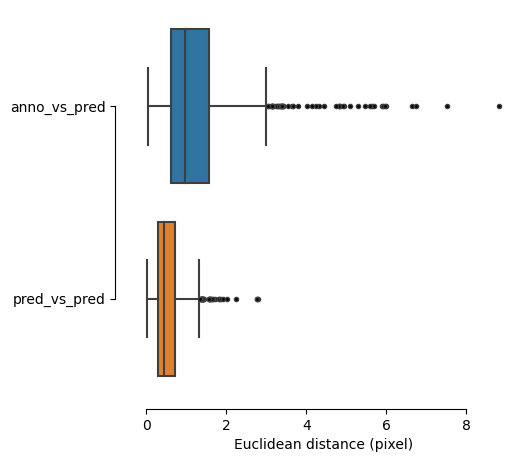

In [23]:
plt.figure(figsize=(5, 5))
sns.boxplot(x="error", y="group",
            flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 3},
            data=err)
sns.despine(offset=10, trim=True)
plt.ylabel("")
plt.xlabel("Euclidean distance (pixel)")